# Inverse design of bimaterial LCE lattice: long strip


## Imports

In [13]:
from morphing_lattices.optimization import ForwardProblem, OptimizationProblem
from morphing_lattices.structure import Lattice, ControlParams
from morphing_lattices.geometry import triangular_lattice_points, triangular_lattice_connectivity
from morphing_lattices.plotting import plot_lattice, generate_animation
import pandas as pd
import jax.numpy as jnp
from jax._src.config import config
config.update("jax_enable_x64", True)  # enable float64 type
from pathlib import Path
import matplotlib.pyplot as plt
%matplotlib widget
plt.style.use(["science", "grid"])


## Import experimental material params


In [14]:
exp_actuation_strain = pd.read_csv(
    '../exp/mechanical_data/20230512_HTNI_LTNI_actuationstrains_highgranularityTemp3355.csv'
).drop(['Unnamed: 3'], axis=1)
exp_modulus_fine = pd.read_csv(
    '../exp/mechanical_data/youngs_mod_LCEstrips_DataForBertoldiGroup_updated202307.csv'
)
exp_modulus_fine.columns = [
    'Temp',
    'LTNI_avg_young',
    'LTNI_stdev',
    'HTNI_avg_young',
    'HTNI_stdev',
]
exp_modulus_fine.drop([0, 1], inplace=True)
exp_modulus_fine = exp_modulus_fine.reset_index(drop=True)

HTNI_stretch_data = exp_actuation_strain[
    ['temp [C]', 'AVG HTNI', 'STD HTNI']
].astype(float)
LTNI_stretch_data = exp_actuation_strain[
    ['temp [C]', 'AVG LTNI', 'STD LTNI']
].astype(float)
HTNI_modulus_data_fine = exp_modulus_fine[
    ['Temp', 'HTNI_avg_young']
].astype(float)
LTNI_modulus_data_fine = exp_modulus_fine[
    ['Temp', 'LTNI_avg_young']
].astype(float)


def HTNI_stretch(temperature):
    return jnp.interp(temperature, jnp.array(HTNI_stretch_data['temp [C]']), jnp.array(HTNI_stretch_data['AVG HTNI']))


def LTNI_stretch(temperature):
    return jnp.interp(temperature, jnp.array(LTNI_stretch_data['temp [C]']), jnp.array(LTNI_stretch_data['AVG LTNI']))


def HTNI_young_fit_fine(temperature):
    return jnp.interp(temperature, jnp.array(HTNI_modulus_data_fine['Temp']), jnp.array(HTNI_modulus_data_fine['HTNI_avg_young']))


def LTNI_young_fit_fine(temperature):
    return jnp.interp(temperature, jnp.array(LTNI_modulus_data_fine['Temp']), jnp.array(LTNI_modulus_data_fine['LTNI_avg_young']))

## Optimization problem

### Temperature evolution

In [15]:
sampled_temperatures = jnp.array([
    22, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80, 85, 90, 95, 100, 105, 110, 115, 120, 125, 130
])

simulation_time = 9000.  # s
sampled_times = jnp.linspace(0, simulation_time, sampled_temperatures.shape[0])


def temperature_fn(t):
    return jnp.interp(t, sampled_times, sampled_temperatures)


def young_1_fn(t):
    return HTNI_young_fit_fine(temperature_fn(t))


def young_2_fn(t):
    return LTNI_young_fit_fine(temperature_fn(t))


def thermal_strain_1_fn(t):
    return (HTNI_stretch(temperature_fn(t))-1.)*0.8


def thermal_strain_2_fn(t):
    return (LTNI_stretch(temperature_fn(t))-1.)*0.7

### Forward problem

(<Figure size 1500x500 with 1 Axes>,
 <Axes: title={'center': 'Lattice'}, xlabel='$x$', ylabel='$y$'>)

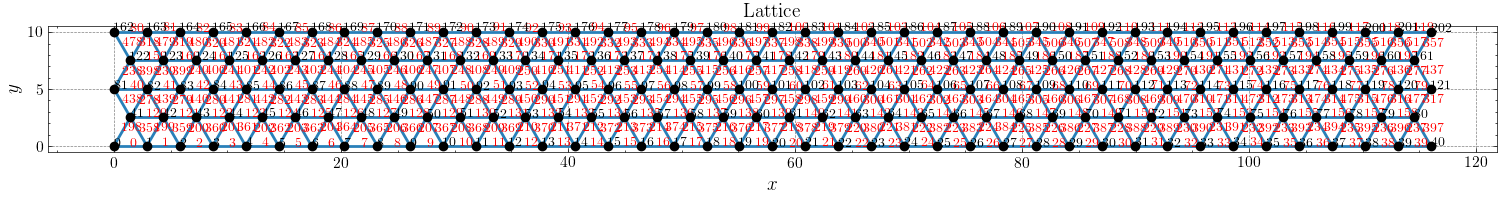

In [16]:
n1 = 40
n2 = 4
spacing = 2.9  # mm
points = triangular_lattice_points(n1=n1, n2=n2, spacing=spacing)
connectivity, horiz_bonds_even, horiz_bonds_odd, right_lean_even, right_lean_odd, left_lean_even, left_lean_odd = triangular_lattice_connectivity(
    n1=n1,
    n2=n2
)

n_points = points.shape[0]
n_bonds = connectivity.shape[0]

control_params = ControlParams(
    reference_points=points,  # mm
    young=jnp.ones(n_bonds),  # MPa
    area=jnp.ones(n_bonds)*(4*0.125**2),  # mm^2
    thermal_strain=-0.25*jnp.ones(n_bonds),
    damping=0.03*jnp.ones((n_points, 2)),
    masses=1.*jnp.ones((n_points, 2)),
    # NOTE: This is the initial guess for the material distribution
    phase=0.5*jnp.ones(n_bonds),#jnp.linspace(0, 1, n_bonds),  # NOTE: 0 means HTNI, 1 means LTNI
)
lattice = Lattice(
    connectivity=connectivity,
    control_params=control_params
)
problem = ForwardProblem(
    lattice=lattice,
    simulation_time=simulation_time,
    n_timepoints=sampled_temperatures.shape[0],
)
problem.setup(
    young_1_fn=young_1_fn,
    young_2_fn=young_2_fn,
    thermal_strain_1_fn=thermal_strain_1_fn,
    thermal_strain_2_fn=thermal_strain_2_fn,
    temperature_fn = temperature_fn,
)
plot_lattice(lattice=lattice, figsize=(15, 5), annotate=True)

### Optimization


#### Target points

In [17]:
# Select the centerline points
target_points_ids = jnp.arange(n2//2*n1+1, (n2//2+1)*n1+2)

optimization_name = 'W_M'
target1_points = lattice.control_params.reference_points[target_points_ids] + jnp.array([
    jnp.linspace(1, -1, target_points_ids.shape[0])*20,
    -jnp.abs(jnp.sin(jnp.linspace(0, 2*jnp.pi, target_points_ids.shape[0]))*5)
]).T

target2_points = lattice.control_params.reference_points[target_points_ids] + jnp.array([
    jnp.linspace(1, -1, target_points_ids.shape[0])*20,
    jnp.abs(jnp.sin(jnp.linspace(0, 2*jnp.pi, target_points_ids.shape[0]))*5)
]).T


# optimization_name = 'W_U'
# target1_points = lattice.control_params.reference_points[target_points_ids] + jnp.array([
#     jnp.linspace(1, -1, target_points_ids.shape[0])*20,
#     -jnp.abs(jnp.sin(jnp.linspace(0, 2*jnp.pi, target_points_ids.shape[0]))*5)
# ]).T

# target2_points = lattice.control_params.reference_points[target_points_ids] + jnp.array([
#     jnp.linspace(1, -1, target_points_ids.shape[0])*20,
#     (jnp.linspace(-jnp.pi, jnp.pi, target_points_ids.shape[0])**2)*2
# ]).T


# sine wave -> U
# optimization_name = 'snake_U'
# target1_points = lattice.control_params.reference_points[target_points_ids] + jnp.array([
#     jnp.linspace(1, -1, target_points_ids.shape[0])*20,
#     jnp.sin(jnp.linspace(0, 2*jnp.pi, target_points_ids.shape[0]))*5
# ]).T

# target2_points = lattice.control_params.reference_points[target_points_ids] + jnp.array([
#     jnp.linspace(1, -1, target_points_ids.shape[0])*20,
#     (jnp.linspace(-jnp.pi, jnp.pi, target_points_ids.shape[0])**2)*2
# ]).T


# U -> sine wave
# optimization_name = 'U_snake'
# target1_points = lattice.control_params.reference_points[target_points_ids] + jnp.array([
#     jnp.linspace(1, -1, target_points_ids.shape[0])*20,
#     (jnp.linspace(-jnp.pi, jnp.pi, target_points_ids.shape[0])**2)*2
# ]).T

# target2_points = lattice.control_params.reference_points[target_points_ids] + jnp.array([
#     jnp.linspace(1, -1, target_points_ids.shape[0])*20,
#     jnp.sin(jnp.linspace(0, 2*jnp.pi, target_points_ids.shape[0]))*5
# ]).T


# Sine -> sine
# optimization_name = 'snake'
# target1_points = lattice.control_params.reference_points[target_points_ids] + jnp.array([
#     jnp.linspace(1, -1, target_points_ids.shape[0])*20,
#     jnp.sin(jnp.linspace(0, 2*jnp.pi, target_points_ids.shape[0]))*10
# ]).T

# target2_points = lattice.control_params.reference_points[target_points_ids] + jnp.array([
#     jnp.linspace(1, -1, target_points_ids.shape[0])*20,
#     -jnp.sin(jnp.linspace(0, 2*jnp.pi, target_points_ids.shape[0]))*10
# ]).T


(16.2, 99.8, 4.7729473419497435, 10.272947341949743)

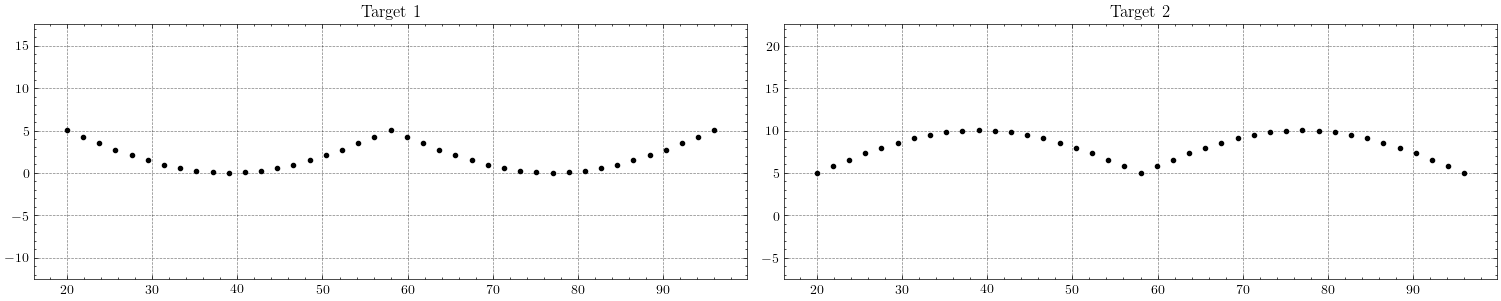

In [19]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 3), constrained_layout=True)
ax1.plot(target1_points[:, 0], target1_points[:, 1],
         'o', color='k', markersize=3)
ax2.plot(target2_points[:, 0], target2_points[:, 1],
         'o', color='k', markersize=3)
ax1.set_title('Target 1')
ax2.set_title('Target 2')
ax1.axis('equal')
ax2.axis('equal')

save_opt_information = True
if save_opt_information:
    out_path = Path(f"{optimization_name}/target_shapes.png")
    out_path.parent.mkdir(parents=True, exist_ok=True)  # Make sure parents directories exist
    plt.savefig(str(out_path), dpi=200)

In [7]:
optimization = OptimizationProblem(
    forward_problem=problem,
    target1_points=target1_points,
    target2_points=target2_points,
    target_points_ids=target_points_ids,
    target1_temperature=70.,
    target2_temperature=130.
)

### Run optimization


In [8]:
optimization.run_optimization_nlopt(
    n_iterations=50,
    # max_time=60,
    lower_bound=0.,
    upper_bound=1.,
)

Iteration: 1
Objective = 0.08599906278929598
Iteration: 2
Objective = 0.08582058782889247
Iteration: 3
Objective = 0.08409209046758193
Iteration: 4
Objective = 0.0653283547813625
Iteration: 5
Objective = 0.0023418362053679465
Iteration: 6
Objective = 0.013199617680790785
Iteration: 7
Objective = 0.0036860869491274705
Iteration: 8
Objective = 0.0014492304767886829
Iteration: 9
Objective = 0.0017856337061852004
Iteration: 10
Objective = 0.0011921418975740002
Iteration: 11
Objective = 0.0011231319315001395
Iteration: 12
Objective = 0.0008571392954759584
Iteration: 13
Objective = 0.031547985607711215
Iteration: 14
Objective = 0.002686544866637778
Iteration: 15
Objective = 0.0008005950880830572
Iteration: 16
Objective = 0.0007708028389007844
Iteration: 17
Objective = 0.0007198625527590201
Iteration: 18
Objective = 0.0010645513529810853
Iteration: 19
Objective = 0.0006343754821056354
Iteration: 20
Objective = 0.0005779864171800012
Iteration: 21
Objective = 0.026048012025002037
Iteration: 22


### Plot the objective values

Text(0.5, 1.0, 'Objective Value Evolution')

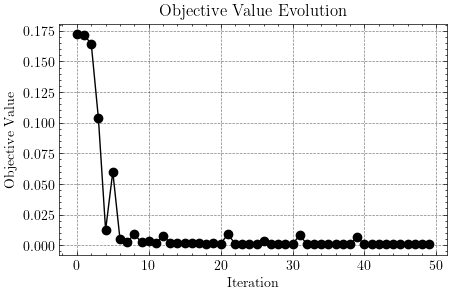

In [19]:
plt.figure(figsize=[5,3])
plt.plot(optimization.objective_values, color='k', marker='o')
plt.xlabel('Iteration')
plt.ylabel('Objective Value')
plt.title('Objective Value Evolution');

In [ ]:
# TODO: explore various target shapes and lattice sizes

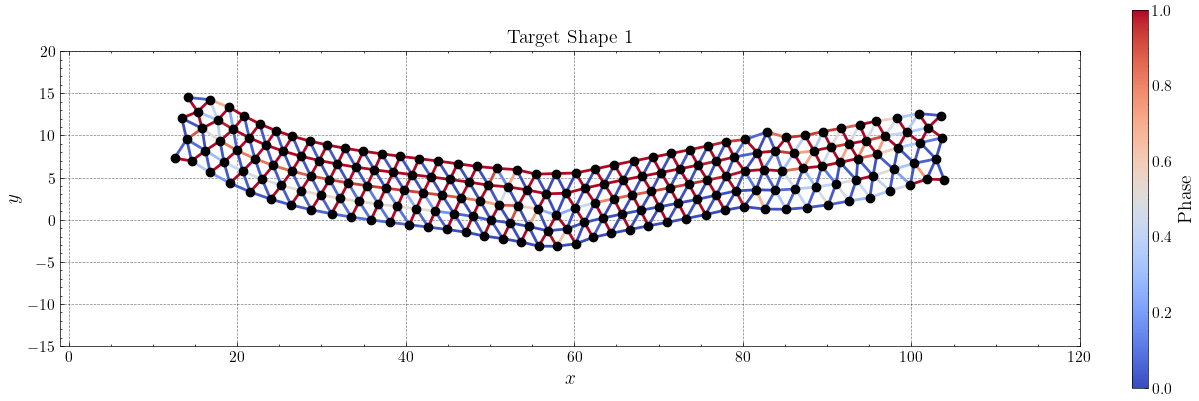

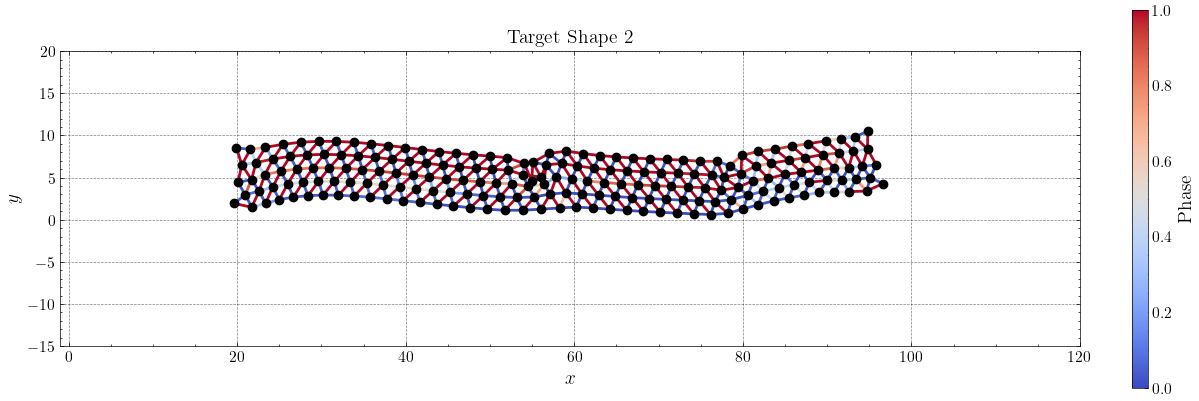

In [23]:
plot_lattice(
    lattice=lattice,
    title='Target Shape 1',
    displacement=optimization.best_response[10, 0],
    bond_values=optimization.best_control_params.phase,
    figsize=(12, 4),
    xlim=(-1, 120),
    ylim=(-15, 20),
    legend_label="Phase",
)

if save_opt_information:
    out_path = Path(f"{optimization_name}/target_shape1_phase_vals.png")
    out_path.parent.mkdir(parents=True, exist_ok=True)  # Make sure parents directories exist
    plt.savefig(str(out_path), dpi=200)

plot_lattice(
    lattice=lattice,
    title='Target Shape 2',
    displacement=optimization.best_response[-1, 0],
    bond_values=optimization.best_control_params.phase,
    figsize=(12, 4),
    xlim=(-1, 120),
    ylim=(-15, 20),
    legend_label="Phase",
)

if save_opt_information:
    out_path = Path(f"{optimization_name}/target_shape2_phase_vals.png")
    out_path.parent.mkdir(parents=True, exist_ok=True)  # Make sure parents directories exist
    plt.savefig(str(out_path), dpi=200)

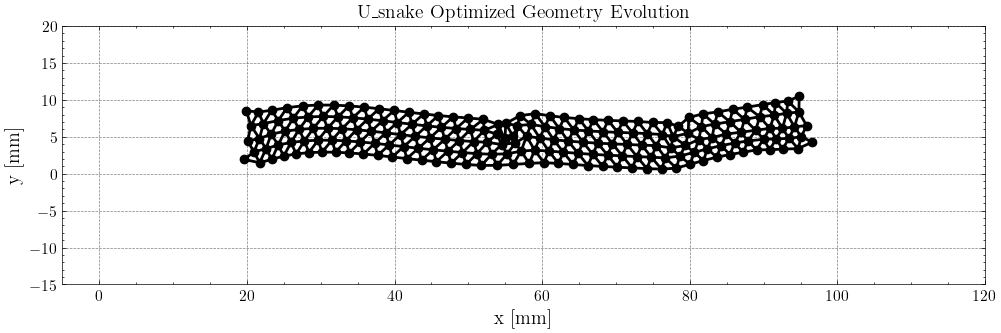

In [24]:
generate_animation(
    lattice=lattice, 
    solution=optimization.best_response, 
    out_filename=f'{optimization_name}/animation', 
    frame_range=jnp.arange(23), 
    xlim=[-5, 120],
    ylim=[-15, 20],
    figsize=[10, 5], 
    x_label='x [mm]',
    y_label='y [mm]',
    title=f'{optimization_name} Optimized Geometry Evolution')

### Impose Discrete Phase Values Corresponding to HTNI and LTNI LCE

In [11]:
phase_threshold = 0.5
discrete_phases = jnp.where(optimization.best_control_params.phase > phase_threshold, 1, 0)

discrete_phase_solution, discrete_control_params = problem.solve(discrete_phases)

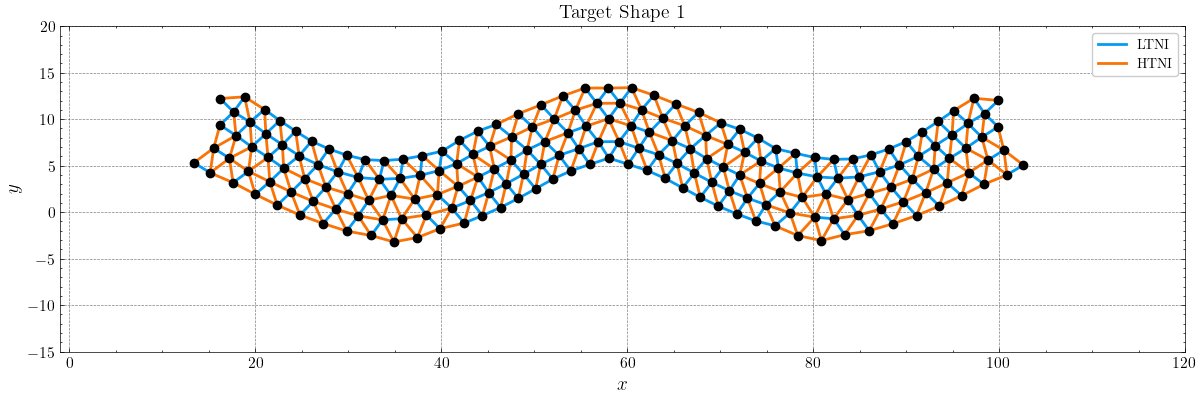

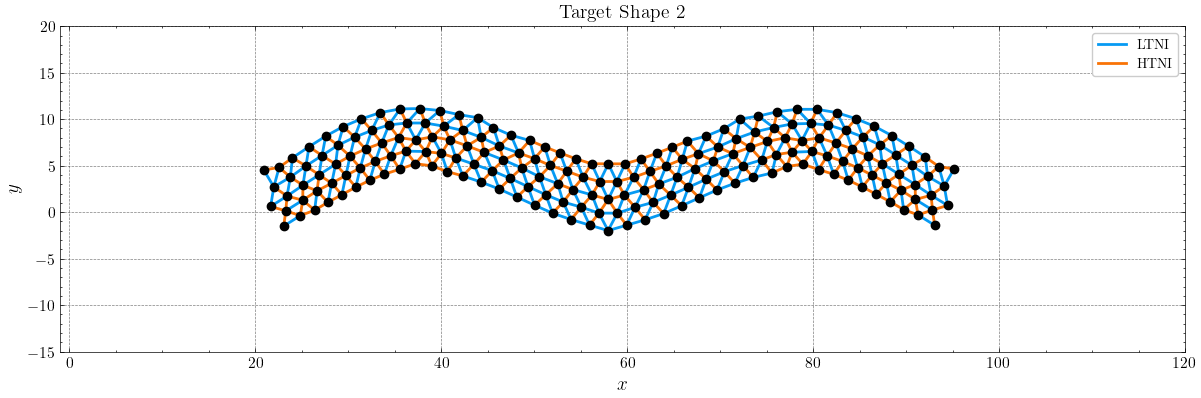

In [13]:
LTNI_bond_indices = jnp.where(discrete_phases == 1)[0]
HTNI_bond_indices = jnp.where(discrete_phases == 0)[0]

plot_lattice(
    lattice=lattice,
    title='Target Shape 1',
    displacement=discrete_phase_solution[10, 0],
    figsize=(12, 4),
    xlim=(-1, 120),
    ylim=(-15, 20),
    HTNI_bond_indices=HTNI_bond_indices,
    LTNI_bond_indices=LTNI_bond_indices,
)

if save_opt_information:
    out_path = Path(f"{optimization_name}/LCE_labeled_target_shape1_phase_vals.png")
    out_path.parent.mkdir(parents=True, exist_ok=True)  # Make sure parents directories exist
    plt.savefig(str(out_path), dpi=200)

plot_lattice(
    lattice=lattice,
    title='Target Shape 2',
    displacement=discrete_phase_solution[-1, 0],
    figsize=(12, 4),
    xlim=(-1, 120),
    ylim=(-15, 20),
    HTNI_bond_indices=HTNI_bond_indices,
    LTNI_bond_indices=LTNI_bond_indices,
)

if save_opt_information:
    out_path = Path(f"{optimization_name}/LCE_labeled_target_shape2_phase_vals.png")
    out_path.parent.mkdir(parents=True, exist_ok=True)  # Make sure parents directories exist
    plt.savefig(str(out_path), dpi=200)

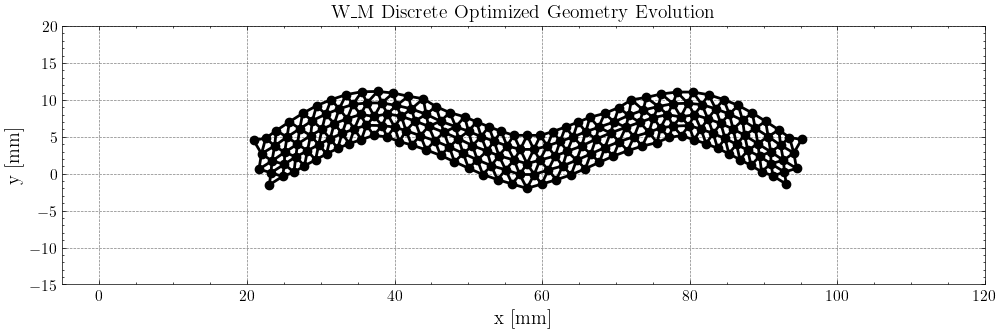

In [14]:
generate_animation(
    lattice=lattice, 
    solution=discrete_phase_solution, 
    out_filename=f'{optimization_name}/discrete_animation', 
    frame_range=jnp.arange(23), 
    xlim=[-5, 120],
    ylim=[-15, 20],
    figsize=[10, 5], 
    x_label='x [mm]',
    y_label='y [mm]',
    title=f'{optimization_name} Discrete Optimized Geometry Evolution')